# Лабораторная работа по OpenCV
## Выполнил:
### Ткачев Алексей Игоревич
### ФИИТ-2, 381806-2, 4 курс


# Подгрузка библоитек и инициализация часто используемого функционала

In [125]:
from cv2 import *
from matplotlib import pyplot as plt
from copy import copy
import numpy as np

Вывод изображений:

In [126]:
def out(img): plt.imshow(img, cmap='gray')

In [127]:
def colored_out(img): plt.imshow(cvtColor(img, COLOR_BGR2RGB))

Сравнение двух изображений:

In [128]:
def compare(img_1, img_2, gray: bool = True):
  if gray:
    _, ax = plt.subplots(1,2)
    ax[0].imshow(img_1, cmap='gray')
    ax[1].imshow(img_2, cmap='gray')
  else:
    _, ax = plt.subplots(1,2)
    ax[0].imshow(cvtColor(img_1, COLOR_BGR2RGB))
    ax[1].imshow(cvtColor(img_2, COLOR_BGR2RGB))

Отрезать кусок от картинки, заданный прямоугольником:

In [129]:
def get_rectangle_from_img(img, rectangle): 
  if len(rectangle == 4):
    return img[rectangle[2]:rectangle[2] + rectangle[3], rectangle[0]:rectangle[0] + rectangle[1]]

Локальный адрес до картинки:

In [130]:
url = 'Lenna.jpg'

Прочтем изображение сразу в GrayScale с помощь параметра `imread(url, ЭТОГО --> 0)`

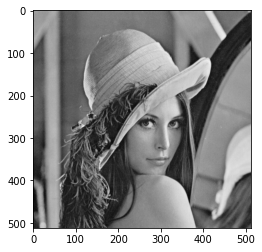

In [131]:
img = imread(url, 0)
img_raw = imread(url)
out(img)

# Детектирование лица


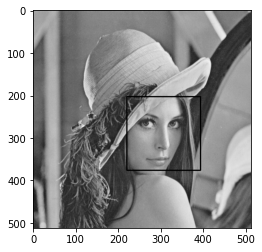

In [132]:
faces = CascadeClassifier('haarcascade_frontalface_alt2.xml').detectMultiScale(img, 1.1, 4)
thickness = 2
for (x, y, w, h) in faces:
    rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), thickness)
out(img)

In [133]:
faces

array([[220, 203, 173, 173]], dtype=int32)

Деформируем область до квадратной

In [134]:
faces = faces[0]
faces[1] += 10
faces[3] += 40
faces

array([220, 213, 173, 213], dtype=int32)

In [135]:
faces[1] == faces[3] # width == height

True

Вырежем найденный квадрат с лицом с помощью срезов. Будем использовать чистое изображение, чтобы не было отрисованного `rectangle`

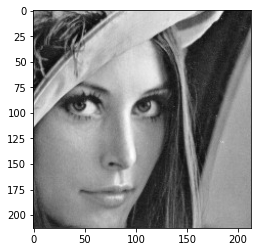

In [136]:
img = get_rectangle_from_img(imread(url, 0).copy(), faces)
out(img)

# Поиск границ

Воспользуемся методом Кенни.

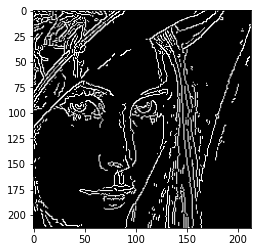

In [137]:
img = Canny(img, 80, 100)
out(img)

In [138]:
before = img.copy()

# Уберем границы $< 10$ по толщине

Задача простая - возьмем каждый контур и отбросим те, у которых минимальная площадь $< 10$

In [139]:
contours, _ = findContours(img, RETR_TREE, CHAIN_APPROX_NONE)
result_contours = [c for c in contours if minAreaRect(c)[1][0] >= 10 or minAreaRect(c)[1][1] >= 10]
len(contours) - len(result_contours)

200

*Было удалено 200 контуров.*

Далее, запомнив нужные контуры, очистим изображение, заполнив матрицу `img` нулями

In [140]:
img.fill(0)
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

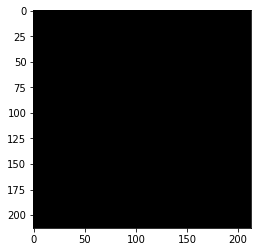

In [141]:
out(img)

А затем снова нанесем их на изображение

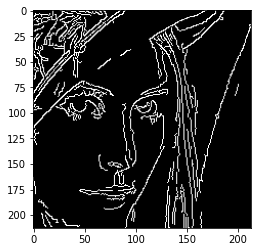

In [142]:
drawContours(img, result_contours, -1, (255, 255, 255), 1)
out(img)

Изображение стало чище.

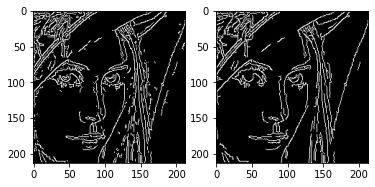

In [143]:
compare(before, img)

In [144]:
before = img.copy()

# Матморфология. Расширение `dilation`.

In [145]:
kernel = np.ones((5, 5), np.uint8)
kernel

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

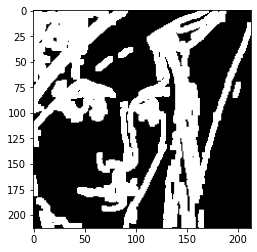

In [146]:
img = dilate(img, kernel)
out(img)

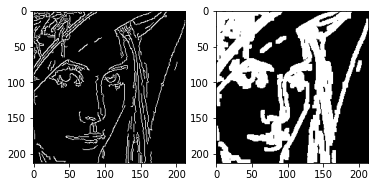

In [147]:
compare(before, img)

In [148]:
before = img.copy()

# Гауссовое размытие

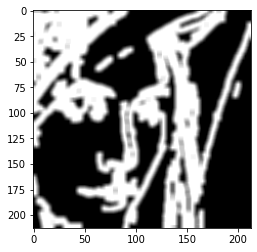

In [149]:
img = GaussianBlur(img, (5,5), BORDER_DEFAULT) 
out(img)

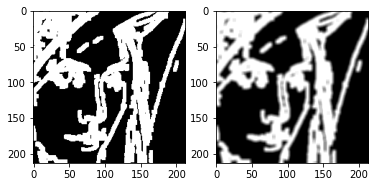

In [150]:
compare(before, img)

In [151]:
before = img.copy()

# Нормализация

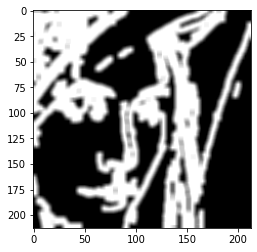

In [152]:
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=NORM_MINMAX, dtype=CV_32F)
out(img)

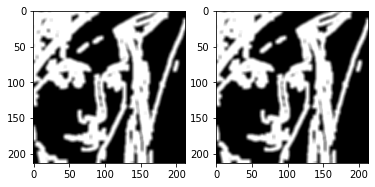

In [153]:
compare(before, img)

In [154]:
before = img.copy()

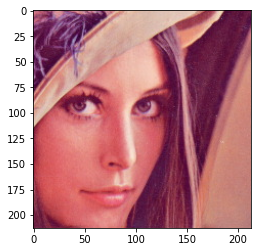

In [155]:
face = get_rectangle_from_img(imread(url), faces)
colored_out(face)

# Билатеральный фильтр

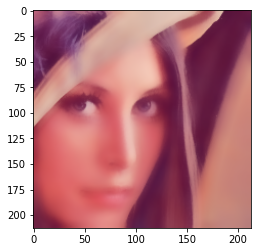

In [156]:
M = img
before = face.copy()
F1 = face.copy()
F1 = bilateralFilter(F1, 15, 175, 175)
plt.imshow(cvtColor(F1, COLOR_BGR2RGB))

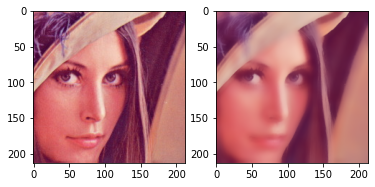

In [157]:
compare(before, F1, gray=False)

In [158]:
before = img.copy()

# Повышение контрастности

In [159]:
F2 = face.copy()
before = face.copy()
sharpness_kernel  = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]], np.int8)
sharpness_kernel

array([[ 0, -1,  0],
       [-1,  5, -1],
       [ 0, -1,  0]], dtype=int8)

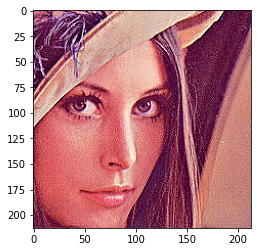

In [160]:
F2 = filter2D(src=F2 , kernel=sharpness_kernel, ddepth=-1)   
plt.imshow(cvtColor(F2, COLOR_BGR2RGB))

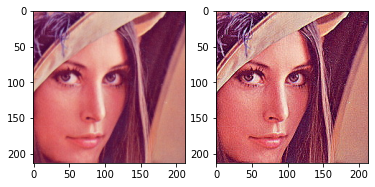

In [161]:
compare(before, F2, gray=False)

# Итоговый фильтр

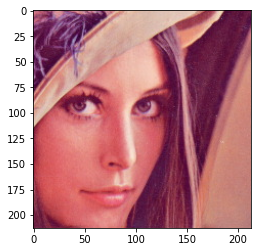

In [162]:
result = face.copy()
colored_out(result)

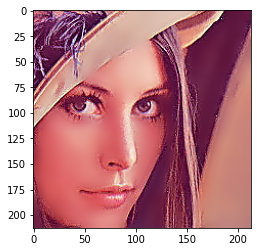

In [163]:
lim_x = result.shape[0]
lim_y = result.shape[1]
for x in range(lim_x):
  for y in range(lim_y):
    for c in range(3):
      result[x][y][c] = M[x][y] * F2[x][y][c] + (1 - M[x][y]) * F1[x][y][c]
colored_out(result)